In [ ]:
!pip install -q -U tensorflow-text --quiet

In [ ]:
!pip install -q tf-models-official

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

# keras uitlity to download a file
dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True, cache_dir='.', cache_subdir='')

In [ ]:
dataset_dir = '/content/aclImdb'

train_dir = os.path.join(dataset_dir,'train')

In [ ]:
# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!. I hate the movie', 'hello world']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/3
625/625 [==============================] - 457s 714ms/step - loss: 0.6224 - binary_accuracy: 0.6222 - val_loss: 0.5156 - val_binary_accuracy: 0.7568
Epoch 2/3
625/625 [==============================] - 354s 566ms/step - loss: 0.4880 - binary_accuracy: 0.7605 - val_loss: 0.4670 - val_binary_accuracy: 0.7858
Epoch 3/3
625/625 [==============================] - 315s 503ms/step - loss: 0.4522 - binary_accuracy: 0.7824 - val_loss: 0.4540 - val_binary_accuracy: 0.7888


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

--2024-03-09 03:56:14--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  16.6MB/s    in 0.3s    

2024-03-09 03:56:14 (16.6 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [ ]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("Details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))

Details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


In [ ]:
## same item id is same as movie id, item id column is renamed as movie id
column_names1 = ['user id','movie id','rating','timestamp']
dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
dataset.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
len(dataset), max(dataset['movie id']),min(dataset['movie id'])

(100000, 1682, 1)

In [ ]:
(100000, 1682, 1)

(100000, 1682, 1)

In [ ]:
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
column_names2

['movie id',
 'movie title',
 'release date',
 'video release date',
 'IMDb URL',
 'unknown',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [ ]:
items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset

In [ ]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
# looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column
len(items_dataset.groupby(by=column_names2[1:])),len(items_dataset)

(1664, 1682)

In [ ]:
merged_dataset = pd.merge(dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()

,user id,movie id,rating,timestamp,movie title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [ ]:
merged_dataset[(merged_dataset['movie title'] == 'Chasing Amy (1997)') & (merged_dataset['user id'] == 894)]

,user id,movie id,rating,timestamp,movie title
4800,894,246,4,882404137,Chasing Amy (1997)
22340,894,268,3,879896041,Chasing Amy (1997)


In [ ]:
refined_dataset = merged_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


In [ ]:
# num_users = len(refined_dataset.rating.unique())
# num_items = len(refined_dataset.movieId.unique())
num_users = len(refined_dataset['user id'].value_counts())
num_items = len(refined_dataset['movie title'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the dataset: {}'.format(num_items))

Unique number of users in the dataset: 943
Unique number of movies in the dataset: 1664


In [ ]:
rating_count_df = pd.DataFrame(refined_dataset.groupby(['rating']).size(), columns=['count'])
rating_count_df

,count
rating,
1.0,6083
1.5,3
2.0,11334
2.5,6
3.0,27060
3.5,19
4.0,34042
4.5,16
5.0,21130


Text(0, 0.5, 'number of ratings')

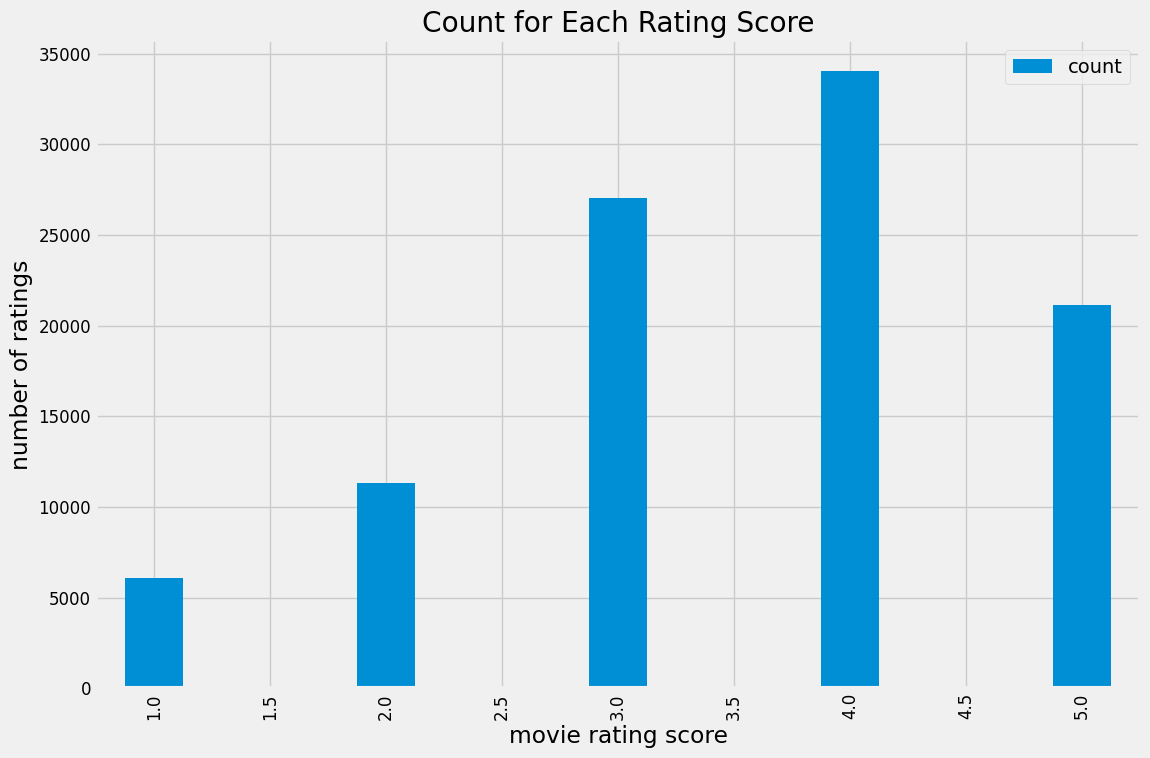

In [ ]:
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [ ]:
total_count = num_items * num_users
zero_count = total_count-refined_dataset.shape[0]
zero_count

1469459

In [ ]:
total_count = num_items * num_users
zero_count = total_count-refined_dataset.shape[0]
zero_count

1469459

In [ ]:
# add log count
rating_count_df['log_count'] = np.log(rating_count_df['count'])
rating_count_df

,count,log_count
rating,,
1.0,6083,8.713253
1.5,3,1.098612
2.0,11334,9.335562
2.5,6,1.791759
3.0,27060,10.205812
3.5,19,2.944439
4.0,34042,10.435350
4.5,16,2.772589
5.0,21130,9.958449


In [ ]:
rating_count_df = rating_count_df.reset_index().rename(columns={'index': 'rating score'})
rating_count_df

,rating,count,log_count
0,1.0,6083,8.713253
1,1.5,3,1.098612
2,2.0,11334,9.335562
3,2.5,6,1.791759
4,3.0,27060,10.205812
5,3.5,19,2.944439
6,4.0,34042,10.435350
7,4.5,16,2.772589
8,5.0,21130,9.958449


Text(0, 0.5, 'number of ratings')

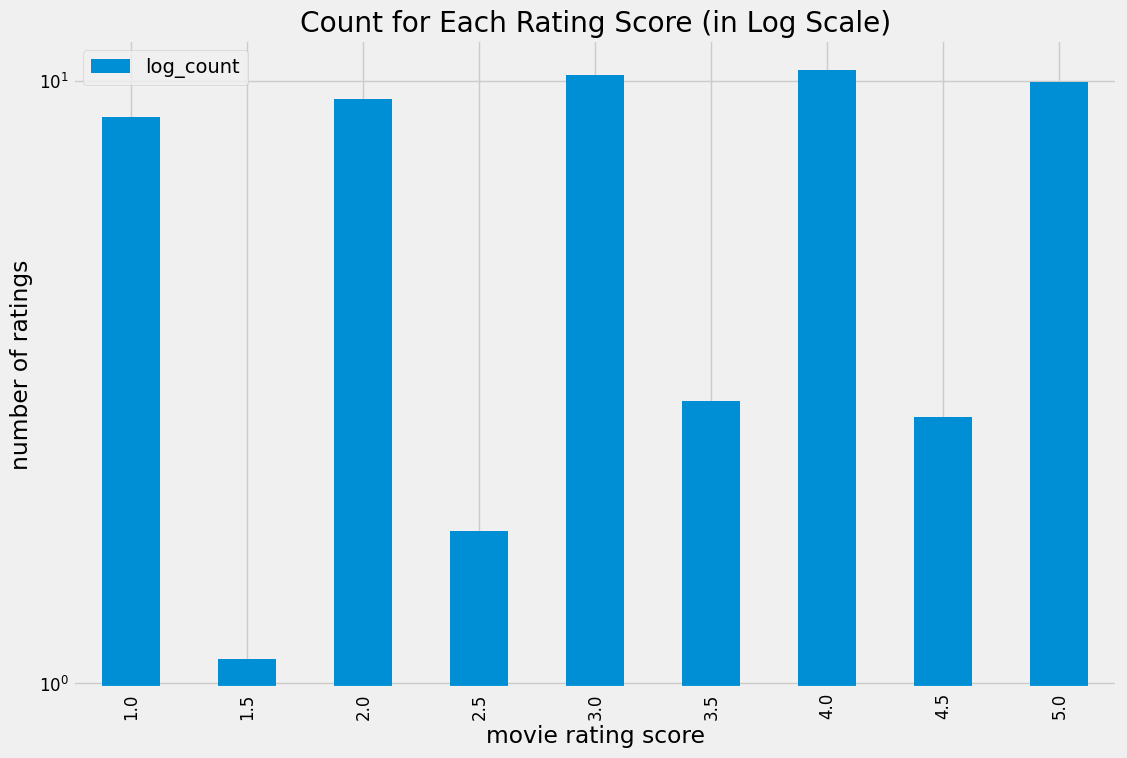

In [ ]:
ax = rating_count_df.plot('rating', 'log_count', 'bar', figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [ ]:
refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


In [ ]:
# get rating frequency
movies_count_df = pd.DataFrame(refined_dataset.groupby('movie title').size(), columns=['count'])
movies_count_df.head()

,count
movie title,
'Til There Was You (1997),9
1-900 (1994),5
101 Dalmatians (1996),109
12 Angry Men (1957),125
187 (1997),41


Text(0, 0.5, 'number of ratings')

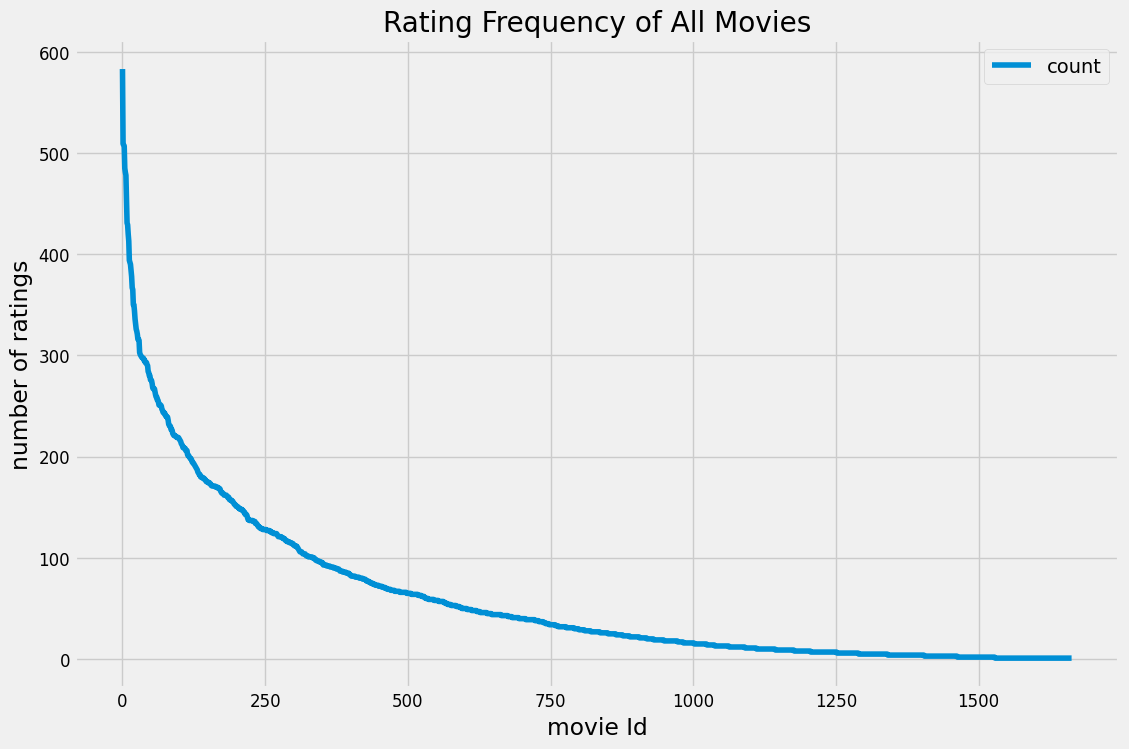

In [ ]:
# plot rating frequency of all movies
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

In [ ]:
# pivot and create movie-user matrix
user_to_movie_df = refined_dataset.pivot(
    index='user id',
     columns='movie title',
      values='rating').fillna(0)

user_to_movie_df.head()

In [ ]:

# transform matrix to scipy sparse matrix
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<943x1664 sparse matrix of type '<class 'numpy.float64'>'
	with 99693 stored elements in Compressed Sparse Row format>

In [ ]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
## function to find top n similar users of the given input user
def get_similar_users(user, n = 5):
  ## input to this function is the user and number of top similar users you want.

  knn_input = np.asarray([user_to_movie_df.values[user-1]])  #.reshape(1,-1)
  # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
  distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)

  print("Top",n,"users who are very much similar to the User-",user, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
  return indices.flatten()[1:] + 1, distances.flatten()[1:]

In [ ]:
from pprint import pprint
user_id = 778
print(" Few of movies seen by the User:")
pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])[:10])
similar_user_list, distance_list = get_similar_users(user_id,5)

 Few of movies seen by the User:
['Amityville Horror, The (1979)',
 'Angels in the Outfield (1994)',
 'Apocalypse Now (1979)',
 'Apollo 13 (1995)',
 'Austin Powers: International Man of Mystery (1997)',
 'Babe (1995)',
 'Back to the Future (1985)',
 'Blues Brothers, The (1980)',
 'Chasing Amy (1997)',
 'Clerks (1994)']
Top 5 users who are very much similar to the User- 778 are: 
 
1 . User: 124 separated by distance of 0.4586649429539592
2 . User: 933 separated by distance of 0.5581959868865324
3 . User: 56 separated by distance of 0.5858413112292744
4 . User: 738 separated by distance of 0.5916272517988691
5 . User: 653 separated by distance of 0.5991479757406326


In [ ]:
similar_user_list, distance_list

(array([124, 933,  56, 738, 653]),
 array([0.45866494, 0.55819599, 0.58584131, 0.59162725, 0.59914798]))

In [ ]:
weightage_list = distance_list/np.sum(distance_list)
weightage_list

array([0.16419139, 0.19982119, 0.20971757, 0.2117888 , 0.21448105])

In [ ]:
mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
mov_rtngs_sim_users

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
movies_list = user_to_movie_df.columns
movies_list

Index([''Til There Was You (1997)', '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)',
       ...
       'Yankee Zulu (1994)', 'Year of the Horse (1997)', 'You So Crazy (1994)', 'Young Frankenstein (1974)', 'Young Guns (1988)', 'Young Guns II (1990)', 'Young Poisoner's Handbook, The (1995)', 'Zeus and Roxanne (1997)', 'unknown', 'Á köldum klaka (Cold Fever) (1994)'],
      dtype='object', name='movie title', length=1664)

In [ ]:
print("Weightage list shape:", len(weightage_list))
print("mov_rtngs_sim_users shape:", mov_rtngs_sim_users.shape)
print("Number of movies:", len(movies_list))

Weightage list shape: 5
mov_rtngs_sim_users shape: (5, 1664)
Number of movies: 1664


In [ ]:
weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
weightage_list.shape

(5, 1664)

In [ ]:
new_rating_matrix = weightage_list*mov_rtngs_sim_users
mean_rating_list = new_rating_matrix.sum(axis =0)
mean_rating_list

array([0.        , 0.        , 1.02879509, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
from pprint import pprint
def recommend_movies(n):
  n = min(len(mean_rating_list),n)
  # print(np.argsort(mean_rating_list)[::-1][:n])
  pprint(list(movies_list[np.argsort(mean_rating_list)[::-1][:n]]))

In [ ]:
print("Movies recommended based on similar users are: ")
recommend_movies(10)

Movies recommended based on similar users are: 
['Star Wars (1977)',
 'Terminator, The (1984)',
 "Schindler's List (1993)",
 'Fugitive, The (1993)',
 'Forrest Gump (1994)',
 'Princess Bride, The (1987)',
 'Empire Strikes Back, The (1980)',
 'Pulp Fiction (1994)',
 'Die Hard (1988)',
 'Monty Python and the Holy Grail (1974)']


In [ ]:
def filtered_movie_recommendations(n):

  first_zero_index = np.where(mean_rating_list == 0)[0][-1]
  sortd_index = np.argsort(mean_rating_list)[::-1]
  sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
  n = min(len(sortd_index),n)
  movies_watched = list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])
  filtered_movie_list = list(movies_list[sortd_index])
  count = 0
  final_movie_list = []
  for i in filtered_movie_list:
    if i not in movies_watched:
      count+=1
      final_movie_list.append(i)
    if count == n:
      break
  if count == 0:
    print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
  else:
    pprint(final_movie_list)

In [ ]:
filtered_movie_recommendations(10)

['Star Wars (1977)',
 "Schindler's List (1993)",
 'Princess Bride, The (1987)',
 'Empire Strikes Back, The (1980)',
 'Return of the Jedi (1983)',
 'Fargo (1996)',
 'Dances with Wolves (1990)',
 'Toy Story (1995)',
 'Braveheart (1995)',
 'Star Trek: First Contact (1996)']


In [ ]:
from pprint import pprint

def recommender_system(user_id, n_similar_users, n_movies): #, user_to_movie_df, knn_model):

  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  # def get_similar_users(user, user_to_movie_df, knn_model, n = 5):
  def get_similar_users(user, n = 5):

    knn_input = np.asarray([user_to_movie_df.values[user-1]])

    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)

    print("Top",n,"users who are very much similar to the User-",user, "are: ")
    print(" ")

    for i in range(1,len(distances[0])):
      print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
    print("")
    return indices.flatten()[1:] + 1, distances.flatten()[1:]


  def filtered_movie_recommendations(n = 10):

    first_zero_index = np.where(mean_rating_list == 0)[0][-1]
    sortd_index = np.argsort(mean_rating_list)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
    n = min(len(sortd_index),n)
    movies_watched = list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])
    filtered_movie_list = list(movies_list[sortd_index])
    count = 0
    final_movie_list = []
    for i in filtered_movie_list:
      if i not in movies_watched:
        count+=1
        final_movie_list.append(i)
      if count == n:
        break
    if count == 0:
      print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
    else:
      pprint(final_movie_list)

  similar_user_list, distance_list = get_similar_users(user_id,n_similar_users)
  weightage_list = distance_list/np.sum(distance_list)
  mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
  movies_list = user_to_movie_df.columns
  weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
  new_rating_matrix = weightage_list*mov_rtngs_sim_users
  mean_rating_list = new_rating_matrix.sum(axis =0)
  print("")
  print("Movies recommended based on similar users are: ")
  print("")
  filtered_movie_recommendations(n_movies)

In [ ]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)
# recommender_system(300, 15,15)

Enter user id
307
number of similar users to be considered
15
Enter number of movies to be recommended:
15
Movie seen by the User:
['12 Angry Men (1957)',
 '2001: A Space Odyssey (1968)',
 'Abyss, The (1989)',
 'Alien (1979)',
 'Apollo 13 (1995)',
 'Back to the Future (1985)',
 'Barbarella (1968)',
 'Batman (1989)',
 'Beauty and the Beast (1991)',
 'Blade Runner (1982)',
 'Blues Brothers, The (1980)',
 'Boot, Das (1981)',
 'Brady Bunch Movie, The (1995)',
 'Braveheart (1995)',
 'Brazil (1985)',
 'Casablanca (1942)',
 'Close Shave, A (1995)',
 'Contact (1997)',
 'Crying Game, The (1992)',
 'Dead Poets Society (1989)',
 'Dial M for Murder (1954)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
 'Dragonheart (1996)',
 'E.T. the Extra-Terrestrial (1982)',
 'Empire Strikes Back, The (1980)',
 'English Patient, The (1996)',
 'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)',
 'Escape from L.A. (1996)',
 'Fargo (1996)',
 'Fast, Cheap & Out 

In [ ]:
# pivot and create movie-user matrix
movie_to_user_df = refined_dataset.pivot(
     index='movie title',
   columns='user id',
      values='rating').fillna(0)

movie_to_user_df.head()

user id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
movie title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [ ]:
# transform matrix to scipy sparse matrix
movie_to_user_sparse_df = csr_matrix(movie_to_user_df.values)
movie_to_user_sparse_df

<1664x943 sparse matrix of type '<class 'numpy.float64'>'
	with 99693 stored elements in Compressed Sparse Row format>

In [ ]:
movies_list = list(movie_to_user_df.index)
movies_list[:10]

["'Til There Was You (1997)",
 '1-900 (1994)',
 '101 Dalmatians (1996)',
 '12 Angry Men (1957)',
 '187 (1997)',
 '2 Days in the Valley (1996)',
 '20,000 Leagues Under the Sea (1954)',
 '2001: A Space Odyssey (1968)',
 '3 Ninjas: High Noon At Mega Mountain (1998)',
 '39 Steps, The (1935)']

In [ ]:
movie_dict = {movie : index for index, movie in enumerate(movies_list)}
print(movie_dict)

{"'Til There Was You (1997)": 0, '1-900 (1994)': 1, '101 Dalmatians (1996)': 2, '12 Angry Men (1957)': 3, '187 (1997)': 4, '2 Days in the Valley (1996)': 5, '20,000 Leagues Under the Sea (1954)': 6, '2001: A Space Odyssey (1968)': 7, '3 Ninjas: High Noon At Mega Mountain (1998)': 8, '39 Steps, The (1935)': 9, '8 1/2 (1963)': 10, '8 Heads in a Duffel Bag (1997)': 11, '8 Seconds (1994)': 12, 'A Chef in Love (1996)': 13, 'Above the Rim (1994)': 14, 'Absolute Power (1997)': 15, 'Abyss, The (1989)': 16, 'Ace Ventura: Pet Detective (1994)': 17, 'Ace Ventura: When Nature Calls (1995)': 18, 'Across the Sea of Time (1995)': 19, 'Addams Family Values (1993)': 20, 'Addicted to Love (1997)': 21, 'Addiction, The (1995)': 22, 'Adventures of Pinocchio, The (1996)': 23, 'Adventures of Priscilla, Queen of the Desert, The (1994)': 24, 'Adventures of Robin Hood, The (1938)': 25, 'Affair to Remember, An (1957)': 26, 'African Queen, The (1951)': 27, 'Afterglow (1997)': 28, 'Age of Innocence, The (1993)': 2

In [ ]:
case_insensitive_movies_list = [i.lower() for i in movies_list]

In [ ]:
knn_movie_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_movie_model.fit(movie_to_user_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
## function to find top n similar users of the given input user
def get_similar_movies(movie, n = 10):
  ## input to this function is the movie and number of top similar movies you want.
  index = movie_dict[movie]
  knn_input = np.asarray([movie_to_user_df.values[index]])
  n = min(len(movies_list)-1,n)
  distances, indices = knn_movie_model.kneighbors(knn_input, n_neighbors=n+1)

  print("Top",n,"movies which are very much similar to the Movie-",movie, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(movies_list[indices[0][i]])

In [ ]:
from pprint import pprint
movie_name = '101 Dalmatians (1996)'

get_similar_movies(movie_name,15)

Top 15 movies which are very much similar to the Movie- 101 Dalmatians (1996) are: 
 
Jack (1996)
Twister (1996)
Willy Wonka and the Chocolate Factory (1971)
Independence Day (ID4) (1996)
Toy Story (1995)
Father of the Bride Part II (1995)
Hunchback of Notre Dame, The (1996)
Lion King, The (1994)
Mrs. Doubtfire (1993)
Jungle Book, The (1994)
Grumpier Old Men (1995)
Mission: Impossible (1996)
Mr. Holland's Opus (1995)
Homeward Bound II: Lost in San Francisco (1996)
Dragonheart (1996)


In [ ]:
# function which takes input and returns suggestions for the user

def get_possible_movies(movie):

    temp = ''
    possible_movies = case_insensitive_movies_list.copy()
    for i in movie :
      out = []
      temp += i
      for j in possible_movies:
        if temp in j:
          out.append(j)
      if len(out) == 0:
          return possible_movies
      out.sort()
      possible_movies = out.copy()

    return possible_movies

In [ ]:
class invalid(Exception):
    pass

def spell_correction():

    try:

      movie_name = input("Enter the Movie name: ")
      movie_name_lower = movie_name.lower()
      if movie_name_lower not in case_insensitive_movies_list :
        raise invalid
      else :
        # movies_list[case_insensitive_country_names.index(movie_name_lower)]
        num_recom = int(input("Enter Number of movie recommendations needed: "))
        get_similar_movies(movies_list[case_insensitive_movies_list.index(movie_name_lower)],num_recom)

    except invalid:

      possible_movies = get_possible_movies(movie_name_lower)

      if len(possible_movies) == len(movies_list) :
        print("Movie name entered is does not exist in the list ")
      else :
        indices = [case_insensitive_movies_list.index(i) for i in possible_movies]
        print("Entered Movie name is not matching with any movie from the dataset . Please check the below suggestions :\n",[movies_list[i] for i in indices])
        spell_correction()


In [ ]:
spell_correction()

In [ ]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_to_user_df.shape[0] * movie_to_user_df.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_to_user_df==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))